In [1]:
import torch

import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
import numpy as np
import matplotlib.pylab as plt

from torch.utils.data import TensorDataset, DataLoader

from viz import (build_graph_viz, 
                 build_node_trace, 
                 build_edge_trace, 
                 simplex_plot, 
                 make_axis)
                   
from utils import (get_edges, 
                   get_nodes, 
                   get_degree, 
                   build_all_to_all, 
                   compute_zdot,
                   compute_drift,
                   compute_social_term,
                   compute_udot,
                   split_agent_option_matrix,
                   euler_integration,
                   build_homogeneous_A,
                   run_homogeneous_simulation,
                   map_to_simplex,
                   generate_random_relative_options,
                   train)

from networks import FullyConnectedNN

# generate a dataset

In [2]:
# hyperparameters 
dt = 1e-2
num_agents = 8
num_options = 2

alpha = 0.2
beta = 0.1   # Should be negative
d = 1.
u = 3.
b = 0.

T_consensus = 10
gamma_consensus = 0.2
delta_consensus = -0.1

T_dissensus = 30
gamma_dissensus = -0.1
delta_dissensus = 0.2

A_tilde = np.ones((num_agents, num_agents)) 
# A_tilde = np.random.randint(2, size=(num_agents, num_agents))
# Opinion matrix of agent i, opinion j
Z = generate_random_relative_options(num_agents, num_options)

Text(0, 0.5, 'z_i')

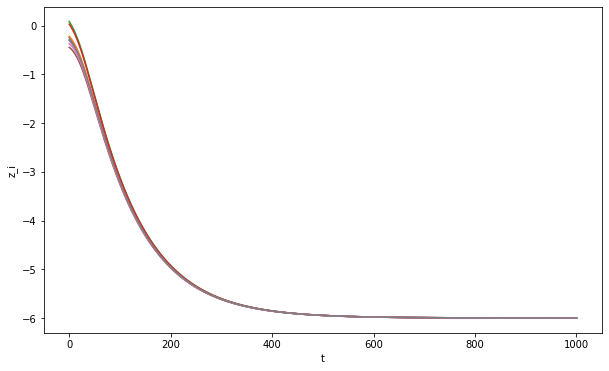

In [3]:
# generate data from figure 2a
Z_t = run_homogeneous_simulation(T_consensus, 
                        dt, 
                        num_agents, 
                        num_options, 
                        gamma_consensus, 
                        delta_consensus,
                        alpha,
                        beta,
                        d,
                        u,
                        b,
                        A_tilde,
                        Z)

plt.figure(figsize=[10,6])
plt.plot(Z_t[:,:,0]) # Question: why do we only plot option 0?
plt.xlabel('t')
plt.ylabel('z_i')

In [4]:
batch_size = 32

x_tensor = torch.Tensor(Z_t[:-1, ...].reshape(-1, num_agents * num_options))
y_tensor = torch.Tensor(Z_t[1:, ...].reshape(-1, num_agents * num_options))
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# build a model

In [12]:
# hyperparameters
learning_rate = 0.001
num_epochs = 10
indim = num_agents * num_options
outdim = num_agents * num_options
hdim = 100
num_hidden = 2
print_every = 100

In [13]:
fcnet = FullyConnectedNN(indim, outdim, hdim, num_hidden)

In [14]:
params = fcnet.parameters()
num_params = np.sum([np.prod(p.shape) for p in params])
print('The number of parameters in the network is: {}'.format(num_params))

The number of parameters in the network is: 13416


In [15]:
loss_fcn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(fcnet.parameters(), lr=learning_rate)

In [16]:
# make weights trainable
fcnet.train()

# run training loop
training_loss = train(num_epochs, print_every, dataloader, loss_fcn, optimizer, fcnet)

Epoch: 0, Iteration: 0, Loss: 28.74
Epoch: 1, Iteration: 0, Loss: 1.15
Epoch: 2, Iteration: 0, Loss: 0.03
Epoch: 3, Iteration: 0, Loss: 0.00
Epoch: 4, Iteration: 0, Loss: 0.00
Epoch: 5, Iteration: 0, Loss: 0.00
Epoch: 6, Iteration: 0, Loss: 0.00
Epoch: 7, Iteration: 0, Loss: 0.00
Epoch: 8, Iteration: 0, Loss: 0.00
Epoch: 9, Iteration: 0, Loss: 0.00


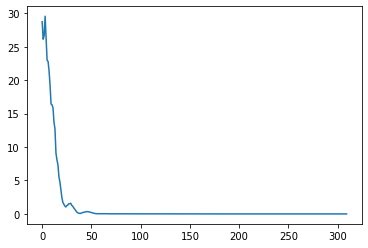

In [17]:
plt.plot(training_loss)

In [24]:
# see the results
num_time_steps = x_tensor.shape[0]
Z_0 = x_tensor[0, :].reshape(1, -1)
Z_t_pred = [Z_0]
for i in range(num_time_steps - 1):
    Z_t_next_pred = fcnet(Z_t_pred[-1])
    Z_t_pred.append(Z_t_next_pred)

In [41]:
Z_t_pred_np = np.asarray([z_t_pred.data.numpy().reshape(1, 8, 2) for z_t_pred in Z_t_pred]).squeeze(1)

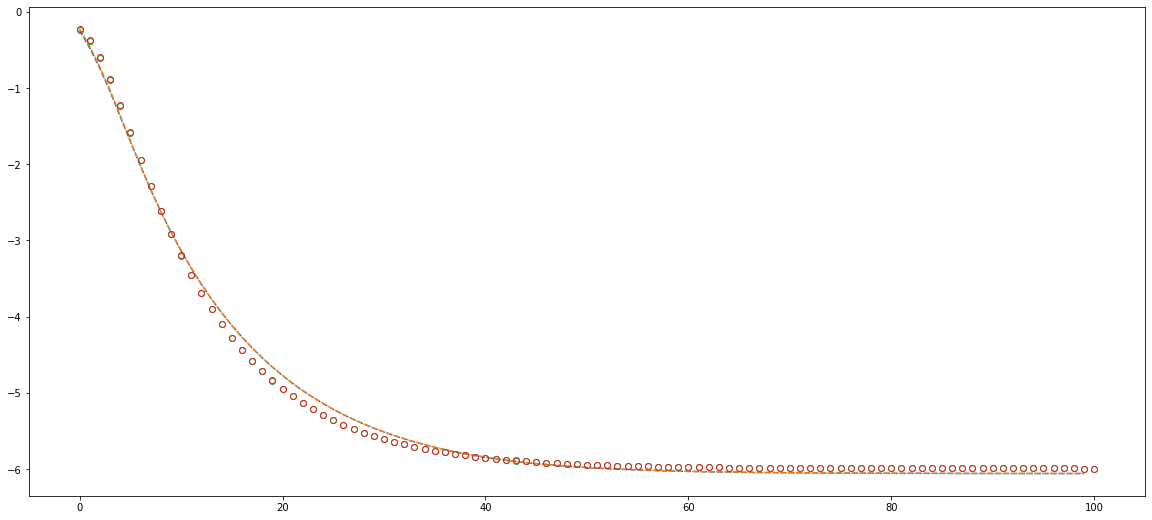

In [52]:
plt.figure(figsize=[20, 9])
plt.plot(Z_t_pred_np[::10,:2,0], '--')
plt.plot(Z_t[::10,:2,0], 'o', fillstyle='none')